## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [17]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [18]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = (''.join(text)).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2023-12-14 08:45:58--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2023-12-14 08:45:59 (7.77 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = (''.join(text)).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
#tokens = sorted(set(out))
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [75]:
# dict <index>:<char>
# Your great code here
id2tok = {id: tok for id, tok in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
tok2id = {tok: i for i, tok in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
# Your code here

In [8]:
import numpy as np

def to_matrix(rows, max_len=None, pad=tok2id[' '], dtype='int32', batch_first = True):

    max_len = (max_len or max(map(len, rows)))
    rows_ids = np.zeros([len(rows), max_len], dtype) + pad

    for i in range(len(rows)):
        line_ids = [tok2id[c] for c in rows[i]]
        rows_ids[i, :len(line_ids)] = line_ids

    if not batch_first:
        rows_ids = np.transpose(rows_ids)

    return rows_ids

In [9]:
import re

rows = re.split('\n\n\s*[a-z]*\n\n', text)
temp = []
for i in range(0, len(rows)):
  if len(rows[i]) > 590:
    temp.append(rows[i])

rows = temp

In [12]:
to_matrix(rows, max_len=2473)

array([[60, 53, 62, ..., 76, 75, 81],
       [45,  1, 59, ...,  1,  1,  1]], dtype=int32)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class CharRNNCell(nn.Module):
    def __init__(self, input_dim=len(tokens), out_dim=128, sequence_length=10):
        super(self.__class__, self).__init__()
        self.sequence_length = sequence_length
        self.embedding = nn.Embedding(input_dim, out_dim)
        self.rnn_update = nn.Linear(out_dim + sequence_length, sequence_length)
        self.rnn_to_logits = nn.Linear(sequence_length, input_dim)

    def forward(self, x, prev):
        x = self.embedding(x)
        x = torch.cat([x, prev], dim=1)
        next = self.rnn_update(x)
        next = torch.tanh(next)
        logits = self.rnn_to_logits(next)
        return F.log_softmax(logits, -1), next

    def initial_hidden(self, batch_size):
        start = torch.zeros(batch_size, self.sequence_length, requires_grad=True)
        return start

In [14]:
def loop(rnn_model, batch):
    batch_size, max_len = batch.shape
    hidden_state = rnn_model.initial_hidden(batch_size)
    probs = []
    for i in batch.transpose(0, 1):
        logit, hidden_state = rnn_model(i, hidden_state)
        probs.append(logit)
    return torch.stack(probs, dim=1)

In [16]:
rnn_cell = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(rnn_cell.parameters(), lr=0.001)

In [18]:
class RNNDataset(torch.utils.data.Dataset):
    def __init__(self, sequence_length=10):
        self.sequence_length = sequence_length
        self.text = [tok2id[c] for c in text]

    def __len__(self):
        return len(self.text) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.text[index:index+self.sequence_length]),
            torch.tensor(self.text[index+1:index+self.sequence_length+1]),
        )

In [19]:
SEQUENCE_LENGTH = 15
BATCH_SIZE = 32
NUM_EPOCHS = 20

dataset = RNNDataset(sequence_length=SEQUENCE_LENGTH)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

In [20]:
for batch in dataloader:
    print(batch)
    break

[tensor([[ 0, 26,  0,  0, 43, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62],
        [26,  0,  0, 43, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45],
        [ 0,  0, 43, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57],
        [ 0, 43, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57, 72],
        [43, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57, 72, 66],
        [57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57, 72, 66,  1],
        [59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57, 72, 66,  1, 68],
        [54,  1, 49, 76, 49, 76,  1, 62, 45, 57, 72, 66,  1, 68, 50],
        [ 1, 49, 76, 49, 76,  1, 62, 45, 57, 72, 66,  1, 68, 50, 62],
        [49, 76, 49, 76,  1, 62, 45, 57, 72, 66,  1, 68, 50, 62, 63],
        [76, 49, 76,  1, 62, 45, 57, 72, 66,  1, 68, 50, 62, 63, 58],
        [49, 76,  1, 62, 45, 57, 72, 66,  1, 68, 50, 62, 63, 58, 72],
        [76,  1, 62, 45, 57, 72, 66,  1, 68, 50, 62, 63, 58, 72, 66],
        [ 1, 62, 45, 57, 72, 66,  1, 68, 50, 62, 63, 58, 72, 66,  1],
        [62, 45, 57

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [24]:
# Your plot code here
from tqdm.auto import tqdm

def full_loop(rnn_cell, num_epochs: int, loader, optimizer, crtiterion, history):
    rnn_cell.train()
    for epoch in tqdm(range(NUM_EPOCHS)):
        h = rnn_cell.initial_hidden(SEQUENCE_LENGTH)
        for inputs, labels in dataloader:
            preds = loop(rnn_cell, inputs)
            actual_next_tokens = torch.LongTensor(labels)
            loss = criterion(
              preds.contiguous().view(-1, len(tokens)),
              actual_next_tokens.contiguous().view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        history.append(loss.item())

losses = []
full_loop(rnn_cell, NUM_EPOCHS, dataloader, opt, criterion, losses)

  0%|          | 0/20 [00:00<?, ?it/s]

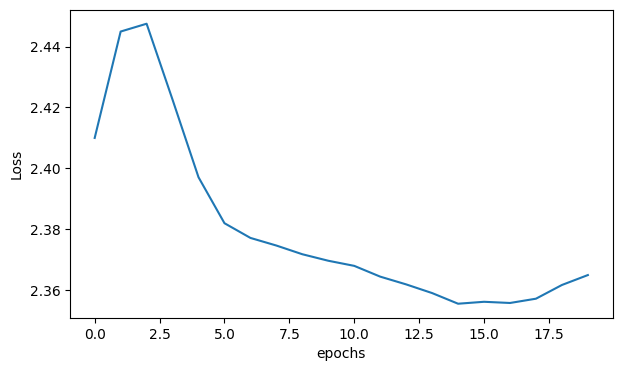

In [26]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(losses)
ax.set_xlabel("epochs")
ax.set_ylabel("Loss")
plt.show()

In [43]:
MAX_LENGTH = 100

def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    #x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = [tok2id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    #hid_state = char_rnn.initial_state(batch_size=1)
    hid_state = char_rnn.initial_hidden(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [45]:
print(generate_sample(rnn_cell, seed_phrase="To be, or not to be".lower(), max_length=100, temperature=1.0))

to be, or not to berxxi

у на
тона, в сели дат, евдири, недавоел
в нцогрить
обищевладам пумо кохи ня


In [46]:
print(generate_sample(rnn_cell, seed_phrase="To be, or not to be".lower(), max_length=100, temperature=0.2))

to be, or not to bene в не не просто ста в вели сени стат мова с водна не в в боста в сто во в поста


In [47]:
print(generate_sample(rnn_cell, seed_phrase="баба с возy".lower(), max_length=100, temperature=0.2))

баба с возyю стат не ста сто в ста сто сто в и не не не в стань сто и не на не в свостат в пола стал


In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [51]:
# Your beautiful code here

class LSTM(nn.Module):
    def __init__(self, input_dim=len(tokens), out_dim=128, num_layers=1):
        super(self.__class__, self).__init__()
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_dim, self.out_dim)
        self.lstm = nn.LSTM(
            input_size=self.out_dim,
            hidden_size=self.out_dim,
            num_layers=self.num_layers
        )
        self.rnn_to_logit = nn.Linear(self.out_dim, input_dim)

    def forward(self, x, prev):
        emb = self.embedding(x)
        out, next = self.lstm(emb, prev)
        logits = self.rnn_to_logit(out)
        return logits, next

    def initial_hidden(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.out_dim),
                torch.zeros(self.num_layers, sequence_length, self.out_dim))

In [52]:
model = LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
losses = []

def lstm_loop(model, num_epochs: int, sequence_length, loader, optimizer, crtiterion, history):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        (hid, curr) = model.initial_hidden(sequence_length)
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            preds, (h, c) = model(torch.LongTensor(inputs), (hid, curr))
            loss = criterion(preds.transpose(1, 2), torch.LongTensor(labels))
            hid.detach_()
            curr.detach_()
            loss.backward()
            optimizer.step()
        history.append(loss.item())

lstm_loop(model, NUM_EPOCHS, SEQUENCE_LENGTH, dataloader, optimizer, criterion, losses)

  0%|          | 0/20 [00:00<?, ?it/s]

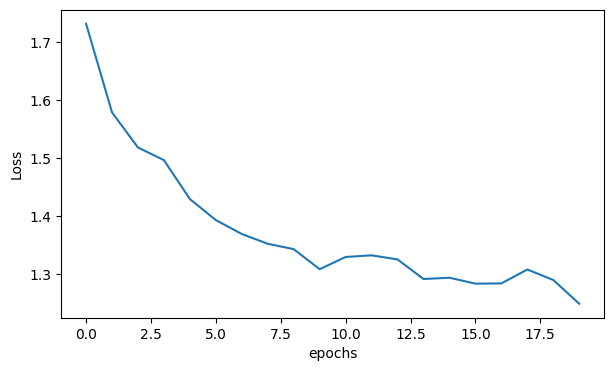

In [53]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(losses)
ax.set_xlabel("epochs")
ax.set_ylabel("Loss")
plt.show()

In [78]:
def generate_sample(model, seed_phrase='Hello', max_length=MAX_LENGTH, temperature=1.0):
    model.eval()
    hid, curr = model.initial_hidden(len(seed_phrase))
    for i in range(0, max_length):
        x = torch.tensor([[tok2id[c] for c in seed_phrase[i:]]])
        preds, (hid, curr) = model(x, (hid, curr))
        last_char_logits = preds[0][-1]
        p = torch.nn.functional.softmax(last_char_logits / temperature, dim=0).detach().numpy()
        char_idx = np.random.choice(len(last_char_logits), p=p)
        seed_phrase = seed_phrase + id2tok[char_idx]
    return seed_phrase

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [79]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperatures:
    print(f"text generation with temperature T = {temp}")
    print(generate_sample(model, seed_phrase='мама мыла', temperature=temperature, max_length=200))
    print()

text generation with temperature T = ['письмо татьяны предо мною;\nего я свято берегу,\nчитаю с тайною тоскою\nи начитаться не могу.\nкто ей внушал и эту нежность,\nи слов любезную небрежность?\nкто ей внушал умильный вздор,\nбезумный сердца разговор,\nи увлекательный и вредный?\nя не могу понять. но вот\nнеполный, слабый перевод,\nс живой картины список бледный,\nили разыгранный фрейшиц\nперстами робких учениц:\n\n\nписьмо татьяны к онегину\n\nя к вам пишу – чего же боле?\nчто я могу еще сказать?\nтеперь, я знаю, в вашей воле\nменя презреньем наказать.\nно вы, к моей несчастной доле\nхоть каплю жалости храня,\nвы не оставите меня.\nсначала я молчать хотела;\nповерьте: моего стыда\nвы не узнали б никогда,\nкогда б надежду я имела\nхоть редко, хоть в неделю раз\nв деревне нашей видеть вас,\nчтоб только слышать ваши речи,\nвам слово молвить, и потом\nвсё думать, думать об одном\nи день и ночь до новой встречи.\nно говорят, вы нелюдим;\nв глуши, в деревне всё вам скучно,\nа мы… ничем мы н

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

In [81]:
lstm_save_dir = "./saved_models/"
name = "lstm_poetry"
torch.save(model.state_dict(), lstm_save_dir + name)

In [82]:
downloaded_model = LSTM()
downloaded_model.load_state_dict(torch.load(lstm_save_dir + name))
print(generate_sample(downloaded_model, temperature=0.2, seed_phrase='у лукоморья', max_length=200))

у лукоморья в смелива
и мог онегина страсти не мог
дали бы в сумася в суждений
и так был проститель свете,
и так далек так должны подруга,
и так для с ним в сумася вашей красавицы
с ним страсти не снегенства мой


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)